In [308]:
import sys
import os
import csv
import numpy as np
import random

random.seed(0)

In [309]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

In [209]:
folder = "ovarian_data/"
files = sorted(os.listdir(folder))
print(files)

['E.MTAB.386_eset_clindata.csv', 'E.MTAB.386_eset_exprs.csv', 'GSE12418_eset_clindata.csv', 'GSE12418_eset_exprs.csv', 'GSE12470_eset_clindata.csv', 'GSE12470_eset_exprs.csv', 'GSE13876_eset_clindata.csv', 'GSE13876_eset_exprs.csv', 'GSE14764_eset_clindata.csv', 'GSE14764_eset_exprs.csv', 'GSE17260_eset_clindata.csv', 'GSE17260_eset_exprs.csv', 'GSE18520_eset_clindata.csv', 'GSE18520_eset_exprs.csv', 'GSE19829.GPL570_eset_clindata.csv', 'GSE19829.GPL570_eset_exprs.csv', 'GSE19829.GPL8300_eset_clindata.csv', 'GSE19829.GPL8300_eset_exprs.csv', 'GSE20565_eset_clindata.csv', 'GSE20565_eset_exprs.csv', 'GSE2109_eset_clindata.csv', 'GSE2109_eset_exprs.csv', 'GSE26193_eset_clindata.csv', 'GSE26193_eset_exprs.csv', 'GSE26712_eset_clindata.csv', 'GSE26712_eset_exprs.csv', 'GSE30161_eset_clindata.csv', 'GSE30161_eset_exprs.csv', 'GSE32062.GPL6480_eset_clindata.csv', 'GSE32062.GPL6480_eset_exprs.csv', 'GSE32063_eset_clindata.csv', 'GSE32063_eset_exprs.csv', 'GSE44104_eset_clindata.csv', 'GSE44104

In [210]:
valid_files = ['E.MTAB.386_eset_clindata.csv','E.MTAB.386_eset_exprs.csv','GSE13876_eset_clindata.csv',
               'GSE13876_eset_exprs.csv','GSE17260_eset_clindata.csv','GSE17260_eset_exprs.csv',
               'GSE26712_eset_clindata.csv','GSE26712_eset_exprs.csv', 'GSE9891_eset_clindata.csv',
               'GSE9891_eset_exprs.csv', 'TCGA_eset_clindata.csv', 'TCGA_eset_exprs.csv',
               'GSE18520_eset_clindata.csv','GSE18520_eset_exprs.csv','GSE19829.GPL8300_eset_clindata.csv',
               'GSE19829.GPL8300_eset_exprs.csv','PMID17290060_eset_clindata.csv','PMID17290060_eset_exprs.csv']
len(valid_files)

18

In [211]:
# THIS TAKES A WHILE TO RUN
# turn csv files into array to store in dictionary

expr_datasets = {} # file name -> 2d array row = patient, col = gene
pheno_datasets = {} # file name -> 2d array row = patient, col = phenotype

for file in files:
    if file in valid_files:
        dataset = []

        with open(folder + file, newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=',', quotechar='"')
            for row in reader:
                dataset.append([row[0].upper()] + row[1:])  # turn gene names to upper case

        if '_eset_exprs.csv' in file:
            dataset = np.transpose(dataset)  # need to flip since csv files have row = gene, col = patient
            sorted_dataset = dataset[:,np.argsort(dataset[0])]
            expr_datasets[file.replace('_eset_exprs.csv', '')] = sorted_dataset
        elif '_eset_clindata.csv' in file:
            pheno_datasets[file.replace('_eset_clindata.csv', '')] = np.asarray(dataset)
        else:
            raise Exception

In [212]:
print(len(list(expr_datasets.keys())))
print(len(list(pheno_datasets.keys())))

9
9


In [213]:
for key in expr_datasets:
    print(expr_datasets[key].shape)
    print(pheno_datasets[key].shape)
    break

(130, 10358)
(130, 32)


In [214]:
def intersect_features(num_studies, expr_datasets):
    intersected = []
    count = 0
    for i, key in enumerate(list(expr_datasets.keys())):
        if i >= 0: # not in [1,2,9,10,16,19,20]:
            genes = expr_datasets[key][0][1:] # trim first empty string
            if len(intersected) == 0:
                intersected = genes
            else:
                intersected = np.intersect1d(intersected, genes)

            count += 1
            if num_studies and count >= num_studies:
                return (intersected)

In [215]:
num_studies = 9 # 15 training + 1 test group of 4 last studies
features = intersect_features(num_studies, expr_datasets)
len(features)

6063

In [216]:
clean_expr_datasets = {} # file name -> 2d array row = patient, col = gene
clean_pheno_datasets = {} # file name -> 2d array row = patient, col = phenotype
count = 0
for key in pheno_datasets:
    dataset = pheno_datasets[key]
    index = np.argwhere(dataset[0] == "summarystage")[0][0]
    valid_patient_indices = (dataset[:,index] != "NA")
    print(valid_patient_indices.shape)
    clean_expr_datasets[key] = expr_datasets[key][valid_patient_indices]
    print(expr_datasets[key][valid_patient_indices].shape)
    clean_pheno_datasets[key] = dataset[valid_patient_indices]
    print(dataset[valid_patient_indices].shape)
    break

(130,)
(130, 10358)
(130, 32)


In [217]:
clean_expr_datasets = {} # file name -> 2d array row = patient, col = gene
count = 0
for key in expr_datasets:
    dataset = expr_datasets[key]
    feature_col_mask = np.isin(dataset[0],features)
    feature_col_mask[0] = True  # include patient names
    valid_patient_mask = np.all(dataset[:,feature_col_mask] != "NA", axis=1) # make sure gene values exist here
    print(dataset[:,feature_col_mask].shape)
    print(valid_patient_mask.shape)
    print(dataset[:,feature_col_mask][valid_patient_mask].shape)
    print(pheno_datasets[key][valid_patient_indices].shape)
    break

(130, 6064)
(130,)
(130, 6064)
(130, 32)


In [218]:
# filter out intersected features for patients w valid feature values (feature name in first value of each row)
def filter_datasets_by_features(num_studies, eds, pds):
    clean_expr_datasets = {} # file name -> 2d array row = patient, col = gene
    clean_pheno_datasets = {} # file name -> 2d array row = patient, col = phenotype
    count = 0
    for i, key in enumerate(list(eds.keys())):
        if i >= 0: # not in [1,2,9,10,16,19,20]:
            dataset = eds[key]
            feature_col_mask = np.isin(dataset[0],features)
            feature_col_mask[0] = True  # include patient names
            valid_patient_mask = np.all(dataset[:,feature_col_mask] != "NA", axis=1) # make sure gene values exist here
            clean_expr_datasets[key] = dataset[:,feature_col_mask][valid_patient_mask]
            clean_pheno_datasets[key] = pds[key][valid_patient_mask]

            count += 1
            if count >= num_studies:
                return clean_expr_datasets, clean_pheno_datasets

# get rid of patients in eds and pds with null pheno_name
def filter_datasets_by_phenotype(num_studies, pheno_name, eds, pds):
    clean_expr_datasets = {} # file name -> 2d array row = patient, col = gene
    clean_pheno_datasets = {} # file name -> 2d array row = patient, col = phenotype
    count = 0
    
    for key in pds:
        dataset = pds[key]
        index = np.argwhere(dataset[0] == pheno_name)[0][0]
        valid_patient_indices = (dataset[:,index] != "NA")
        clean_expr_datasets[key] = eds[key][valid_patient_indices]
        clean_pheno_datasets[key] = dataset[valid_patient_indices]
        
        count += 1
        if count >= num_studies:
            return clean_expr_datasets, clean_pheno_datasets

In [219]:
filtered_features_eds, filtered_features_pds = filter_datasets_by_features(num_studies, expr_datasets, pheno_datasets)
assert (len(filtered_features_eds) == num_studies)
for key in filtered_features_eds:
    assert (len(filtered_features_eds[key][0]) == len(features) + 1)

In [220]:
for key in filtered_features_pds:
    print(filtered_features_pds[key].shape)
    break

(130, 32)


In [221]:
# find a good phenotype

pheno_try = 'vital_status'
pheno_pos = 'deceased'
num_pos = 0
num_total = 0
for key in filtered_features_pds:
    print(key)
    dataset = filtered_features_pds[key]
    index = np.argwhere(dataset[0] == pheno_try)[0][0]
    valid_patient_indices = (dataset[:,index] != "NA")
    labels = dataset[valid_patient_indices][:,index][1:] == pheno_pos # .astype(float) > pheno_pos
    num_total += len(labels)
    num_pos += np.count_nonzero(labels)
    print(labels)
print(num_pos * 1.0 / num_total)

E.MTAB.386
[False False False  True  True  True  True  True False False  True False
  True  True  True False  True  True False  True False False  True False
  True  True  True  True  True False  True  True  True  True  True False
 False False  True  True  True  True False  True False  True  True False
  True False False False False False  True  True  True  True  True False
 False  True  True  True False  True  True False False False False  True
 False  True False  True  True  True False  True  True  True False  True
 False False False  True False False False False  True  True  True False
 False False False False False False False  True  True  True False False
  True  True  True  True  True  True False  True  True False False  True
  True  True  True  True  True False  True  True False]
GSE13876
[ True  True False  True  True  True  True  True False  True  True  True
  True False  True False  True  True  True False False  True  True  True
  True  True  True False False False  True  True

In [222]:
# set phenotype here:
pheno_name = 'vital_status'
pheno_pos = 'deceased'

clean_expr_datasets, clean_pheno_datasets = filter_datasets_by_phenotype(
    num_studies, pheno_name, filtered_features_eds, filtered_features_pds
)
# assert (len(filtered_pheno_eds) == len(filtered_pheno_pds))
# for key in filtered_pheno_eds:
#     assert (len(filtered_pheno_eds[key]) == len(filtered_pheno_pds[key]))

In [52]:
# def clean_datasets(n, pheno, eds, pds):
#     clean_eds, clean_pds = filter_datasets_by_features(n, eds, pds)
#     return filter_datasets_by_phenotype(n, pheno, clean_eds, clean_pds)    

In [53]:
# # set phenotype here:
# pheno_name = 'summarystage'

# clean_expr_datasets, clean_pheno_datasets = clean_datasets(num_studies, pheno_name, expr_datasets, pheno_datasets)

In [223]:
# make sure dimensions are right

assert (len(clean_expr_datasets) == num_studies)
assert (len(clean_pheno_datasets) == num_studies)

for key in clean_expr_datasets:
    assert( len(clean_expr_datasets[key][0]) == len( features) + 1 ) # plus 1 for the patient identifiers
    try:
        assert ((clean_expr_datasets[key][0][1:] == list(features)).all())  # make sure order is correct
    except AssertionError:
        e = (clean_expr_datasets[key][0][1:])
        for i in range(len(e)):
            if e[i] != features[i]:
                print (e[i])
                print(features[i])
        raise Exception
    assert (len(clean_expr_datasets[key]) == len(clean_pheno_datasets[key])) # make sure same num patients

In [224]:
num_train_studies = 6  # rest are test studies
test_studies = ['GSE18520','GSE19829.GPL8300','PMID17290060']

In [225]:
# X, Y, A
# each patient has gene expression x from study ID a with phenotype label y (let's do summarystage?)

# X_test, Y_test, A_test (15th study = test?)

# count stuff
total_num = 0  # total number of samples
train_num = 0
test_num = 0
count = 0
train_study_nums = {} # key -> number of samples
for key in clean_expr_datasets:
    num_samples = len(clean_expr_datasets[key]) - 1 # ignore gene name column
    assert (num_samples == len(clean_pheno_datasets[key]) - 1)
    total_num += num_samples
    
    if key not in test_studies: # count < num_train_studies: #
#         print("train", key)
        train_study_nums[key] = (num_samples)
        train_num += num_samples
    else:
        print("test", key)
        test_num += num_samples
    count += 1
print(total_num)
print(train_num)
print(test_num)
print(min(train_study_nums.values()))

test GSE18520
test GSE19829.GPL8300
test PMID17290060
1635
1423
212
110


In [226]:
sample_size = min(train_study_nums.values())
sampled_inds = {} # key -> sampled indices of len sample_size
for key in train_study_nums:
    n = train_study_nums[key]
    sampled_inds[key] = random.sample(range(n), n) # sample_size)
    print(len(sampled_inds[key]))
# print(sample_size)

129
157
110
185
282
560


In [227]:
# create y label (y_train and y_test)
count = 0
y_train = np.asarray([])
y_test = np.asarray([])
for key in clean_pheno_datasets:
    print(key)
    dataset = clean_pheno_datasets[key]
    index = np.argwhere(dataset[0] == pheno_name)[0][0]
    labels = dataset[:,index][1:] == pheno_pos
    assert len(labels) == len(clean_expr_datasets[key]) - 1
    
    if key not in test_studies: # count < num_train_studies:
        labels = labels[sampled_inds[key]]
        y_train = np.concatenate((y_train, labels.astype(float)))
    else:
        y_test = np.concatenate((y_test, labels.astype(float)))
    count += 1

y_train = np.expand_dims(y_train, 1)
print(np.sum(y_train))
y_train_expand = np.concatenate((1 - y_train, y_train), axis=1)
y_test = np.expand_dims(y_test, 1)
print(np.sum(y_test))
y_test_expand = np.concatenate((1 - y_test, y_test), axis=1)
print(y_train_expand.shape)
print(y_test_expand.shape)

E.MTAB.386
GSE13876
GSE17260
GSE18520
GSE19829.GPL8300
GSE26712
GSE9891
PMID17290060
TCGA
764.0
131.0
(1423, 2)
(212, 2)


In [228]:
# create x label (x_train and x_test)
count = 0
x_train = None
x_test = None
for key in clean_expr_datasets:
    print(key)
    dataset = clean_expr_datasets[key]
    x_study = dataset[1:,1:].astype(float) # get rid of gene names and patient names

    if key not in test_studies: # count < num_train_studies:
        x_study = x_study[sampled_inds[key]]
        if x_train is None:
            x_train = x_study
        else:
            x_train = np.concatenate((x_train, x_study.astype(float)), axis=0)
    else:
        if x_test is None:
            x_test = x_study
        else:
            x_test = np.concatenate((x_test, x_study.astype(float)), axis=0)
    count += 1

from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
# fit only on training data
scaler.fit(x_train)  
x_train = scaler.transform(x_train)  
# apply same transformation to test data
x_test = scaler.transform(x_test) 
print(x_train.shape)
print(x_test.shape)

E.MTAB.386
GSE13876
GSE17260
GSE18520
GSE19829.GPL8300
GSE26712
GSE9891
PMID17290060
TCGA
(1423, 6063)
(212, 6063)


In [229]:
print(type(x_train[128][0]))

<class 'numpy.float64'>


In [230]:
# create study_id arrays
study_ids = []
dim = num_train_studies+1
for i in range(dim):
    study_id = np.zeros(dim)
    study_id[i] = 1
    study_ids.append(study_id)
study_ids

[array([1., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0.]),
 array([0., 0., 1., 0., 0., 0., 0.]),
 array([0., 0., 0., 1., 0., 0., 0.]),
 array([0., 0., 0., 0., 1., 0., 0.]),
 array([0., 0., 0., 0., 0., 1., 0.]),
 array([0., 0., 0., 0., 0., 0., 1.])]

In [231]:
study_index = 0

for key in clean_expr_datasets:
    dataset = clean_expr_datasets[key]  # row = gene, col = patient
    study_id = study_ids[study_index]
    print(study_id.shape)
    num_samples = len(dataset[1:])
    dup_study_ids = np.tile(study_id, (num_samples,1))
    print(dup_study_ids.shape)
    study_index += 1
    break

(7,)
(129, 7)


In [238]:
study_index = 0
attr_train = None
attr_test = None
for key in clean_expr_datasets:
    dataset = clean_expr_datasets[key]  # row = gene, col = patient
    num_samples = len(dataset[1:])

    if key not in test_studies: # study_index < num_train_studies: # 
        study_id = study_ids[study_index]
        dup_study_ids = np.tile(study_id, (num_samples,1))
        if attr_train is None:
            attr_train = dup_study_ids
        else:
            attr_train = np.concatenate((attr_train, dup_study_ids), axis=0)  
        study_index += 1
    else:
        study_id = study_ids[-1]
        dup_study_ids = np.tile(study_id, (num_samples,1))
        if attr_test is None:
            attr_test = dup_study_ids
        else:
            attr_test = np.concatenate((attr_test, dup_study_ids), axis=0)

print(attr_train.shape)
print(attr_test.shape)

(1423, 7)
(212, 7)


In [239]:
print(x_train[0])
print(x_train[0].shape)
print(y_train_expand[0])
print(attr_train[0])

[ 0.66805112 -0.03975443 -0.07168165 ... -0.5260554  -0.01737357
  0.80217536]
(6063,)
[1. 0.]
[1. 0. 0. 0. 0. 0. 0.]


In [240]:
t = x_train.shape[0]
inds_shuffled = np.random.permutation(t)
train_inds = inds_shuffled[:int(.8 * t)]
valid_inds = inds_shuffled[int(.8 * t):]
print(len(train_inds), len(valid_inds))

1138 285


In [241]:
print(y_test_expand.shape)
print(y_test_expand[0])

(212, 2)
[1. 0.]


In [242]:
save_file = 'ovarian_6_studies_3_test_6063_features_all_samples_030921_standard.npz'
np.savez(save_file, 
         x_train = x_train, 
         x_test = x_test, 
         y_train = y_train_expand, 
         y_test = y_test_expand, 
         attr_train = attr_train,
         attr_test = attr_test,
         train_inds = train_inds,
         valid_inds = valid_inds,
         num_train_studies = num_train_studies,
         num_test_studies = num_studies - num_train_studies
        )

## Check files

In [247]:
# bio_infile = 'ovarian_6_studies_3_test_6063_features_all_samples_030921_standard.npz'
bio_infile = "ovarian_6_studies_3_test_6063_features_110_sample_size_020221_standard.npz"
data = np.load(bio_infile)

x_train = data['x_train'][data['train_inds']]
y_train = data['y_train'][data['train_inds']]
attr_train = data['attr_train'][data['train_inds']]

x_valid = data['x_train'][data['valid_inds']]
y_valid = data['y_train'][data['valid_inds']]
attr_valid = data['attr_train'][data['valid_inds']]

x_test = data['x_test']
y_test = data['y_test']
attr_test = data['attr_test']

In [248]:
x_train.shape

(528, 6063)

In [249]:
x_valid.shape

(132, 6063)

In [250]:
x_test.shape

(212, 6063)

In [251]:
np.average(x_test[:,9])

-0.12491268952973736

In [252]:
num_pos = np.sum(y_train[:,1])+np.sum(y_valid[:,1])
total = y_train.shape[0] + y_valid.shape[0]
num_pos/total

0.5696969696969697

In [253]:
# k = 3
# num_samples = 1
# nk = np.ones(k)*5000*num_samples
# ind = np.repeat(0, nk[0])
# for i in range(1, k-1):
#     ind = np.concatenate((ind, np.repeat(i, nk[i])), axis=0)
# attr_train = np.zeros((ind.size, ind.max()+1))
# attr_train[np.arange(ind.size), ind] = 1
# attr_test = np.concatenate( (np.ones((int(nk[-1]), 1)), np.zeros((int(nk[-1]), k-2))), axis=1)
# print(attr_test.shape)
# print(attr_train[0])

# Mixup

In [254]:
def mixup_data_old(x, y, alpha=1.0):
    '''
    Returns mixed inputs, pairs of targets, and lambda
    Code from https://github.com/facebookresearch/mixup-cifar10
    '''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.

    batch_size = x.shape[0]
    index = np.random.permutation(batch_size)

    mixed_x = lam * x + (1. - lam) * x[index]
    mixed_y = lam * y + (1. - lam) * y[index]
    return mixed_x, mixed_y, lam

In [263]:
def mixup_data(x, y, alpha=1.0):
    '''
    Returns mixed inputs, pairs of targets, and lambda
    Code from https://github.com/facebookresearch/mixup-cifar10
    '''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.

    n = x.shape[0]
    batch_size = n * n
    mixed_x = np.zeros((batch_size, x.shape[1]))
    mixed_y = np.zeros((batch_size, y.shape[1]))

    for i in range(n):
        for j in range(n):
            mixed_x[n*i + j] = lam * x[i] + (1. - lam) * x[j]
            mixed_y[n*i + j] = lam * y[i] + (1. - lam) * y[j]

    return mixed_x, mixed_y, lam

In [264]:
# test_x, test_y, lam = mixup_data(x_train, y_train)
# print(test_x.shape)
# print(test_y.shape)
# print(lam)

(278784, 6063)
(278784, 2)


In [83]:
def mixup_data_with_a(x, y, a, alpha=1.0):
    '''
    Returns mixed inputs, pairs of targets, and lambda
    Code from https://github.com/facebookresearch/mixup-cifar10
    '''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.

    batch_size = x.shape[0]
    index = np.random.permutation(batch_size)

    mixed_x = lam * x + (1. - lam) * x[index]
    mixed_y = lam * y + (1. - lam) * y[index]
    mixed_a = lam * a + (1. - lam) * a[index]
    return mixed_x, mixed_y, mixed_a

In [268]:
num_train_studies = len(attr_train[0])-1

# create study_id arrays
study_ids = []
dim = num_train_studies+1
for i in range(dim):
    study_id = np.zeros(dim)
    study_id[i] = 1
    study_ids.append(study_id)
study_ids

[array([1., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0.]),
 array([0., 0., 1., 0., 0., 0., 0.]),
 array([0., 0., 0., 1., 0., 0., 0.]),
 array([0., 0., 0., 0., 1., 0., 0.]),
 array([0., 0., 0., 0., 0., 1., 0.]),
 array([0., 0., 0., 0., 0., 0., 1.])]

In [282]:
n_squared = int(x_train.shape[0]/num_train_studies)**2
total_n = num_train_studies * n_squared
print(total_n)

mixed_x_train = None
mixed_y_train = None
mixed_attr_train = None

start_index = 0
for i in range(num_train_studies):
    study_mask = attr_train[:,i].astype(bool)
    study_x = x_train[study_mask]
    study_y = y_train[study_mask]
    print(study_x.shape)
    print(study_y.shape)
    
    study_mixed_x, study_mixed_y, lam = mixup_data(study_x, study_y)
    print(lam)
    
    study_n = study_mixed_x.shape[0]
    dup_study_ids = np.tile(study_ids[i], (study_n,1))
    if mixed_x_train is None:
        mixed_x_train = study_mixed_x
        mixed_y_train = study_mixed_y
        mixed_attr_train = dup_study_ids
    else:
        mixed_x_train = np.concatenate((mixed_x_train, study_mixed_x.astype(float)), axis=0)
        mixed_y_train = np.concatenate((mixed_y_train, study_mixed_y.astype(float)))
        mixed_attr_train = np.concatenate((mixed_attr_train, dup_study_ids), axis=0) 


46464
(528,)
(85, 6063)
(85, 2)
0.27090891395475064
(528,)
(94, 6063)
(94, 2)
0.9455327187786406
(528,)
(87, 6063)
(87, 2)
0.8559001022772635
(528,)
(90, 6063)
(90, 2)
0.9093140924444223
(528,)
(88, 6063)
(88, 2)
0.22671366595716663
(528,)
(84, 6063)
(84, 2)
0.29823447340767095
(46530, 6063)


In [285]:
print(mixed_x_train.shape)
print(mixed_y_train.shape)
print(mixed_attr_train.shape)
print(mixed_y_train[1])
print(mixed_attr_train[1])

(46530, 6063)
(46530, 2)
(46530, 7)
[0.72909109 0.27090891]
[1. 0. 0. 0. 0. 0. 0.]


In [287]:
t = mixed_x_train.shape[0]
train_inds = np.random.permutation(t)
v = x_valid.shape[0]
valid_inds = np.random.permutation(v)
print(len(train_inds), len(valid_inds))

46530 132


In [319]:
# THIS IS DIFFERENT, NEED TO UPDATE RVR, TRAIN AND VALID SEPARATE NOW BECAUSE MIXUP
# RVR SHOULD SET x_train = x_train[train_inds] and x_valid = x_valid[valid_inds] instead of from x_train

save_file = 'ovarian_6_studies_3_test_6063_features_110_mixup_46530_samples_030921_standard.npz'
np.savez(save_file, 
         x_train = mixed_x_train[train_inds], 
         x_valid = x_valid[valid_inds],
         x_test = x_test, 
         y_train = mixed_y_train[train_inds], 
         y_valid = y_valid[valid_inds],
         y_test = y_test, 
         attr_train = mixed_attr_train[train_inds],
         attr_valid = attr_valid[valid_inds],
         attr_test = attr_test,
#          train_inds = train_inds,
#          valid_inds = valid_inds,
         num_train_studies = num_train_studies,
         num_test_studies = num_studies - num_train_studies
        )

KeyboardInterrupt: 

In [320]:
mixup_infile = "ovarian_6_studies_3_test_6063_features_110_mixup_46530_samples_030921_standard.npz"
data = np.load(mixup_infile)

In [321]:
list(data.keys())

['x_train',
 'x_valid',
 'x_test',
 'y_train',
 'y_valid',
 'y_test',
 'attr_train',
 'attr_valid',
 'attr_test',
 'num_train_studies',
 'num_test_studies']

In [307]:
# print(data['x_train'].shape)
# print(data['y_train'].shape)
# print(data['attr_train'].shape)
# print(data['x_valid'].shape)
# print(data['y_valid'].shape)
# print(data['attr_valid'].shape)
num_pos = np.sum(data['y_test'][:,1]) #+np.sum(y_valid[:,1])
total = data['y_test'].shape[0]
num_pos/total

0.6179245283018868

In [303]:
tf.glorot_uniform_initializer()

# test code 

In [31]:
y_train.shape
np.zeros(x.shape).shape

(64, 6063)

In [197]:
batch_size = x_train.shape[0] # 64
index = np.random.permutation(x_train.shape[0])
x = x_train[index][:batch_size]
y = y_train[index][:batch_size]
a = attr_train[index][:batch_size]
mixed_x, mixed_y, mixed_a = mixup_data_with_a(x, y, a)

In [69]:
mixed_a[2]

array([0.        , 0.        , 0.16610971, 0.        , 0.83389029,
       0.        , 0.        ])

In [123]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(x_train)  
x_train = scaler.transform(x_train)  
# apply same transformation to test data
x_test = scaler.transform(x_test)  

In [312]:
mixup_infile = "ovarian_6_studies_3_test_6063_features_110_mixup_46530_samples_030921_standard.npz"
data = np.load(mixup_infile)
x = data['x_train']
y = data['y_train']
y = np.round(y)
x_test = data['x_test']
y_test = data['y_test']

In [315]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier((10,10), max_iter=500, alpha=1e-4,
                    solver='adam', verbose=0, tol=1e-8, random_state=1,
                    learning_rate_init=.01, batch_size=64)
clf.fit(x, y)
# clf.fit(mixed_x, np.round(mixed_y))

MLPClassifier(batch_size=64, hidden_layer_sizes=(10, 10),
              learning_rate_init=0.01, max_iter=500, random_state=1, tol=1e-08,
              verbose=0)

0.6179245283018868


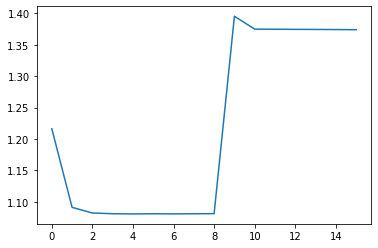

In [316]:
import matplotlib.pyplot as plt
# print(clf.score(mixed_x, mixed_y))
plt.plot(clf.loss_curve_)
# plt.plot(clf.validation_scores_)
print(clf.score(x_test, y_test))

In [161]:
def cross_entropy(target, pred, weights=None, eps=1e-8):
    if weights == None:
        weights = tf.ones_like(pred)
    return -tf.squeeze(tf.multiply(weights, tf.multiply(target, tf.log(pred + eps)) + tf.multiply(1 - target, tf.log(1 - pred + eps))))

In [165]:
t = cross_entropy(y, np.zeros(y.shape))
with tf.Session() as sess:
    print(t.eval())  

[[-9.99999989e-09  1.84206807e+01]
 [-9.99999989e-09  1.84206807e+01]
 [ 1.84206807e+01 -9.99999989e-09]
 ...
 [ 1.84206807e+01 -9.99999989e-09]
 [-9.99999989e-09  1.84206807e+01]
 [ 1.84206807e+01 -9.99999989e-09]]


In [317]:
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.datasets import fetch_mldata
from sklearn.neural_network import MLPClassifier, MLPRegressor
import sklearn
np.random.seed(1)

""" Example based on sklearn's docs """
# mnist = fetch_mldata("MNIST original")
# rescale the data, use the traditional train/test split
# X, y = mnist.data / 255., mnist.target
X_train, X_test = x, x_test
y_train, y_test = y, y_test

mlp = MLPClassifier(hidden_layer_sizes=(10,10), max_iter=1, alpha=1e-4,
                    solver='adam', verbose=0, tol=1e-8, random_state=1,
                    learning_rate_init=.01)

""" Home-made mini-batch learning
    -> not to be used in out-of-core setting!
"""
N_TRAIN_SAMPLES = X_train.shape[0]
N_EPOCHS = 200
N_BATCH = 128
N_CLASSES = np.unique(y_train)

scores_train = []
scores_test = []

loss_train = []
loss_test = []
# EPOCH
epoch = 0
while epoch < N_EPOCHS:
#     print('epoch: ', epoch)
    # SHUFFLING
    random_perm = np.random.permutation(X_train.shape[0])
    mini_batch_index = 0
    num_batches = 0
    while True:
        # MINI-BATCH
        indices = random_perm[mini_batch_index:mini_batch_index + N_BATCH]
        mlp.partial_fit(X_train[indices], y_train[indices], classes=N_CLASSES)
#         print(mlp.loss_curve_)
        mini_batch_index += N_BATCH

        num_batches += 1
        if mini_batch_index >= N_TRAIN_SAMPLES:
            break

#     print(np.average(mlp.loss_curve_[-num_batches:]))
    loss_train.append(np.average(mlp.loss_curve_[-num_batches:]))
    # SCORE TRAIN
    scores_train.append(mlp.score(X_train, y_train))

    # SCORE TEST
    scores_test.append(mlp.score(X_test, y_test))
    
#     train_pred = mlp.predict(X_train[indices])
#     loss_train.append(sklearn.metrics.log_loss(y_train[indices], train_pred))
    
#     test_pred = mlp.predict(X_test)
#     loss_test.append(sklearn.metrics.log_loss(y_test, test_pred))

    epoch += 1

""" Plot """
fig, ax = plt.subplots(2, sharex=True, sharey=True)
ax[0].plot(scores_train)
ax[0].set_title('Train Accuracy')
ax[1].plot(scores_test)
ax[1].set_title('Test Accuracy')
# fig.suptitle("Accuracy over epochs", fontsize=14)
plt.show()

fig, ax = plt.subplots(1, sharex=True, sharey=True)
ax.plot(loss_train)
ax.set_title('Train Loss')
plt.show()

print(loss_train[-1])

print(scores_train[-1])
print(scores_test[-1])

/Users/rachelh/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


KeyboardInterrupt: 

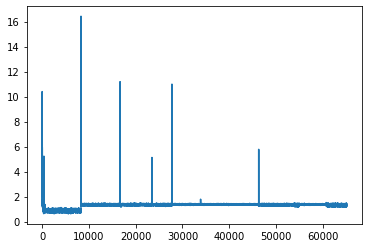

In [318]:
plt.plot(mlp.loss_curve_)

In [3]:
import tensorflow as tf


In [12]:
tf.round(y)

<tf.Tensor 'Round:0' shape=(64, 2) dtype=float64>

In [22]:
pred = np.random.rand(y.shape[0], y.shape[1])
print(pred.shape)
target = y
pred_class = tf.round(pred)
acc = (1.0 - tf.reduce_mean(tf.cast(tf.equal(target, pred_class), tf.float32)))

(64, 2)


In [23]:
with tf.Session() as sess:
    print(acc.eval()) 

0.484375
